# Coastal change and impact analysis

* **Products used:** [DE Africa Coastlines](), [High Resolution Population Density]()


## Background

Coastal changes have a larget impact on human settlements. 

## Description

This notebook will demonstrate how to load relevant datasets and analyse the impact of coastal changes on human settlements.
Topics covered include:

1. Loading DE Africa Coastlines rates of change statistics data using the `get_coastlines` function.
2. Loading High Resolution Population Density.
3. Identify coastal change hotspots that are near pupulated areas.


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

In [2]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.coastal import get_coastlines
from deafrica_tools.plotting import display_map
from datacube.utils.geometry import Geometry


# set s3 region for HRSL data access
import os
os.environ['AWS_DEFAULT_REGION']="us-east-1"
os.environ['AWS_S3_ENDPOINT']="s3.us-east-1.amazonaws.com"

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Select rates of change for country of interest

In [3]:
coastlines = gpd.read_file("../../data/deafricacoastlines_v0.4.0.gpkg", layer="rates_of_change")

In [4]:
african_countries  = gpd.read_file("../Supplementary_data/MGCI/african_countries.geojson")

alt_name = {'Comoros':'Comores','Congo-Brazzaville':'Republic of the Congo', 'Cote d`Ivoire':'Ivory Coast', 
            'Democratic Republic of Congo':'Democratic Republic of the Congo','Somalia':'Federal Republic of Somalia'}
african_countries["COUNTRY_ALT"]=african_countries["COUNTRY"]
for key, value in alt_name.items():
    african_countries.at[african_countries[african_countries["COUNTRY"]==key].index[0], "COUNTRY_ALT"]=value

In [5]:
np.unique(african_countries["COUNTRY"])

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [6]:
country = "Nigeria"

In [7]:
idx = african_countries[african_countries['COUNTRY'] == country].index[0]
country_geom = Geometry(geom=african_countries.iloc[idx].geometry, crs=african_countries.crs)

In [8]:
change_gdf=coastlines[coastlines.country==african_countries.loc[idx].COUNTRY_ALT]

In [18]:
# significant changes

sig_neg_change = change_gdf[(change_gdf.certainty=='good') & (change_gdf.sig_time<0.01) & (change_gdf.rate_time<-1)]
print(len(sig_neg_change)*30./1000.)

358.47


In [19]:
buffer=20
buffered = sig_neg_change.copy()
buffered['geometry'] = sig_neg_change.to_crs('6933').buffer(buffer).to_crs('4326')
hotspots = gpd.overlay(buffered, buffered, how='intersection')

coast_bbox = buffered.unary_union.bounds


In [20]:
display_map(x=(coast_bbox[0], coast_bbox[2]), y=(coast_bbox[1], coast_bbox[3]))

## Loading Population data

In [21]:
# Load population data
ds = rxr.open_rasterio('s3://dataforgood-fb-data/hrsl-cogs/hrsl_general/hrsl_general-latest.vrt', 
                       chunks ={'x': 1000, 'y': 1000})

In [22]:
pop_raster = ds.isel(band=0).sel(x=slice(coast_bbox[0],coast_bbox[2]), y = slice(coast_bbox[3], coast_bbox[1]))
#youth_raster = ds_youth.isel(band=0).sel(x=slice(coastal_bbox[0],coastal_bbox[2]), y = slice(coastal_bbox[3],coastal_bbox[1]))

pop_raster=pop_raster.rename({'x':'longitude','y':'latitude'})
#youth_raster=youth_raster.rename({'x':'longitude','y':'latitude'})

hotspots_mask = xr_rasterize(gdf=hotspots,
                                  da=pop_raster,
                                  transform=pop_raster.geobox.transform,
                                  crs=pop_raster.geobox.crs)

In [23]:
pop_hotspots = (pop_raster*hotspots_mask)

In [24]:
# go over individual hotspots

print("# of hotspots", len(hotspots))

# of hotspots 47243


In [25]:
# Population near hotspots

pop_hotspots.sum().values

array(28861.335668)

### Population within a buffer of 2021 shoreline

In [ ]:
buffer = 50 #meter

In [10]:
# Load DE Africa Coastlines annual shorelines data. 
deacl_shorelines_gdf = get_coastlines(bbox=bbox, 
                                      layer='shorelines')

/usr/local/lib/python3.8/dist-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [12]:
buffered = deacl_shorelines_gdf.copy()
buffered['geometry'] = deacl_shorelines_gdf.to_crs('6933').buffer(buffer).to_crs('4326')
coast_bbox = buffered.unary_union.bounds


In [13]:
coast_bbox

(-11.492598206286239, 4.354116928570664, -7.364591791808162, 6.92300308467692)

In [20]:
pop_raster = ds.isel(band=0).sel(x=slice(coast_bbox[0],coast_bbox[2]), y = slice(coast_bbox[3], coast_bbox[1])).compute()
#youth_raster = ds_youth.isel(band=0).sel(x=slice(coastal_bbox[0],coastal_bbox[2]), y = slice(coastal_bbox[3],coastal_bbox[1]))

pop_raster=pop_raster.rename({'x':'longitude','y':'latitude'})
#youth_raster=youth_raster.rename({'x':'longitude','y':'latitude'})


country_mask = xr_rasterize(gdf=african_countries[african_countries['COUNTRY'] == country],
                                  da=pop_raster,
                                  transform=pop_raster.geobox.transform,
                                  crs=pop_raster.geobox.crs)

In [21]:
coastal_pop = {}
for year in range(2000,2021):
    coastal_area = buffered[buffered.year==str(year)]
    coastal_raster = xr_rasterize(gdf=coastal_area,
                                  da=pop_raster,
                                  transform=pop_raster.geobox.transform,
                                  crs=pop_raster.geobox.crs)
    
    #fraction of coastal population
    coastal_pop[year] = (coastal_raster*pop_raster*country_mask).sum().values
    print(year, coastal_pop[year]) 

2000 5156.297044999997
2001 5287.114126999996
2002 5474.556089999997
2003 5604.860099999998
2004 5525.316232999997
2005 4269.997777
2006 5339.435688999997
2007 5284.808079999997
2008 5053.746324999998
2009 5397.306034999998


/usr/local/lib/python3.8/dist-packages/rasterio/features.py:322: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 0 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


2010 5469.085178999999
2011 5620.986380999999
2012 5509.582841999999
2013 5840.464020999996
2014 5592.673438999996
2015 5499.973896999996
2016 5597.800031999996
2017 5568.492585999998
2018 5876.699521999996
2019 6025.041424999997
2020 5888.408934999996


<AxesSubplot: xlabel='Year', ylabel='Population within 50m from coast (million)'>

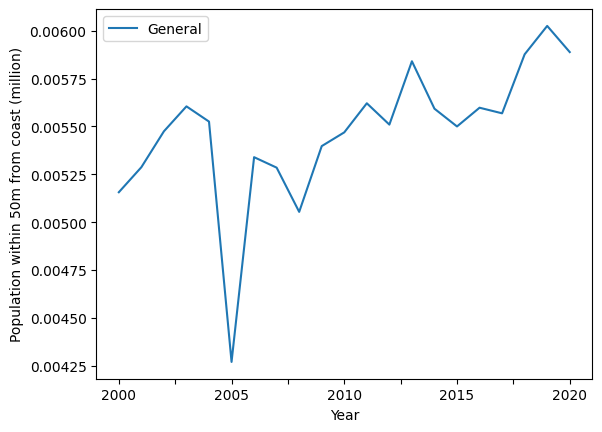

In [22]:
import pandas as pd
import numpy as np

# convert to million
pd.DataFrame(np.array(list(coastal_pop.values()))/1e6, 
             columns=[f'General'], 
             index=[str(x) for x in coastal_pop.keys()]
            ).plot(ylabel=f'Population within {buffer}m from coast (million)',xlabel='Year')